## Semantic segmentation of aerial imagery
### DeepLabV3Plus ResNet34

参考: https://www.kaggle.com/code/killa92/pytorch-miou-0-95-using-deeplabv3/notebook

In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip3 install --upgrade pip
!pip3 install notebook
!pip3 install opencv-python
!pip3 install opencv-contrib-python
!pip3 install -U albumentations
!pip3 install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu118


In [5]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, transformations = None):

        self.im_paths = sorted(glob(f"{root}/*/images/*.jpg"))
        self.gt_paths = sorted(glob(f"{root}/*/masks/*.png"))
        self.transformations = transformations
        self.n_cls = 5
        
        assert len(self.im_paths) == len(self.gt_paths)
        
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])
        
        if self.transformations: im, gt = self.apply_transformations(im, gt)
        
        return im, gt
        
    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path), self.read_im(gt_path)

    def read_im(self, path): return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05]):
        
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    
    ds = CustomSegmentationDataset(root = root, transformations = transformations)
    n_cls = ds.n_cls
    
    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)
    
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
        
    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")
    
    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = 8)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = 8)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = 8)
    
    return tr_dl, val_dl, test_dl, n_cls

# root = "../data/Semantic segmentation dataset"
root = "kikagaku_seg/data/Semantic segmentation dataset"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.augmentations.transforms.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 4)


There are 64 number of images in the train set
There are 3 number of images in the validation set
There are 5 number of images in the test set



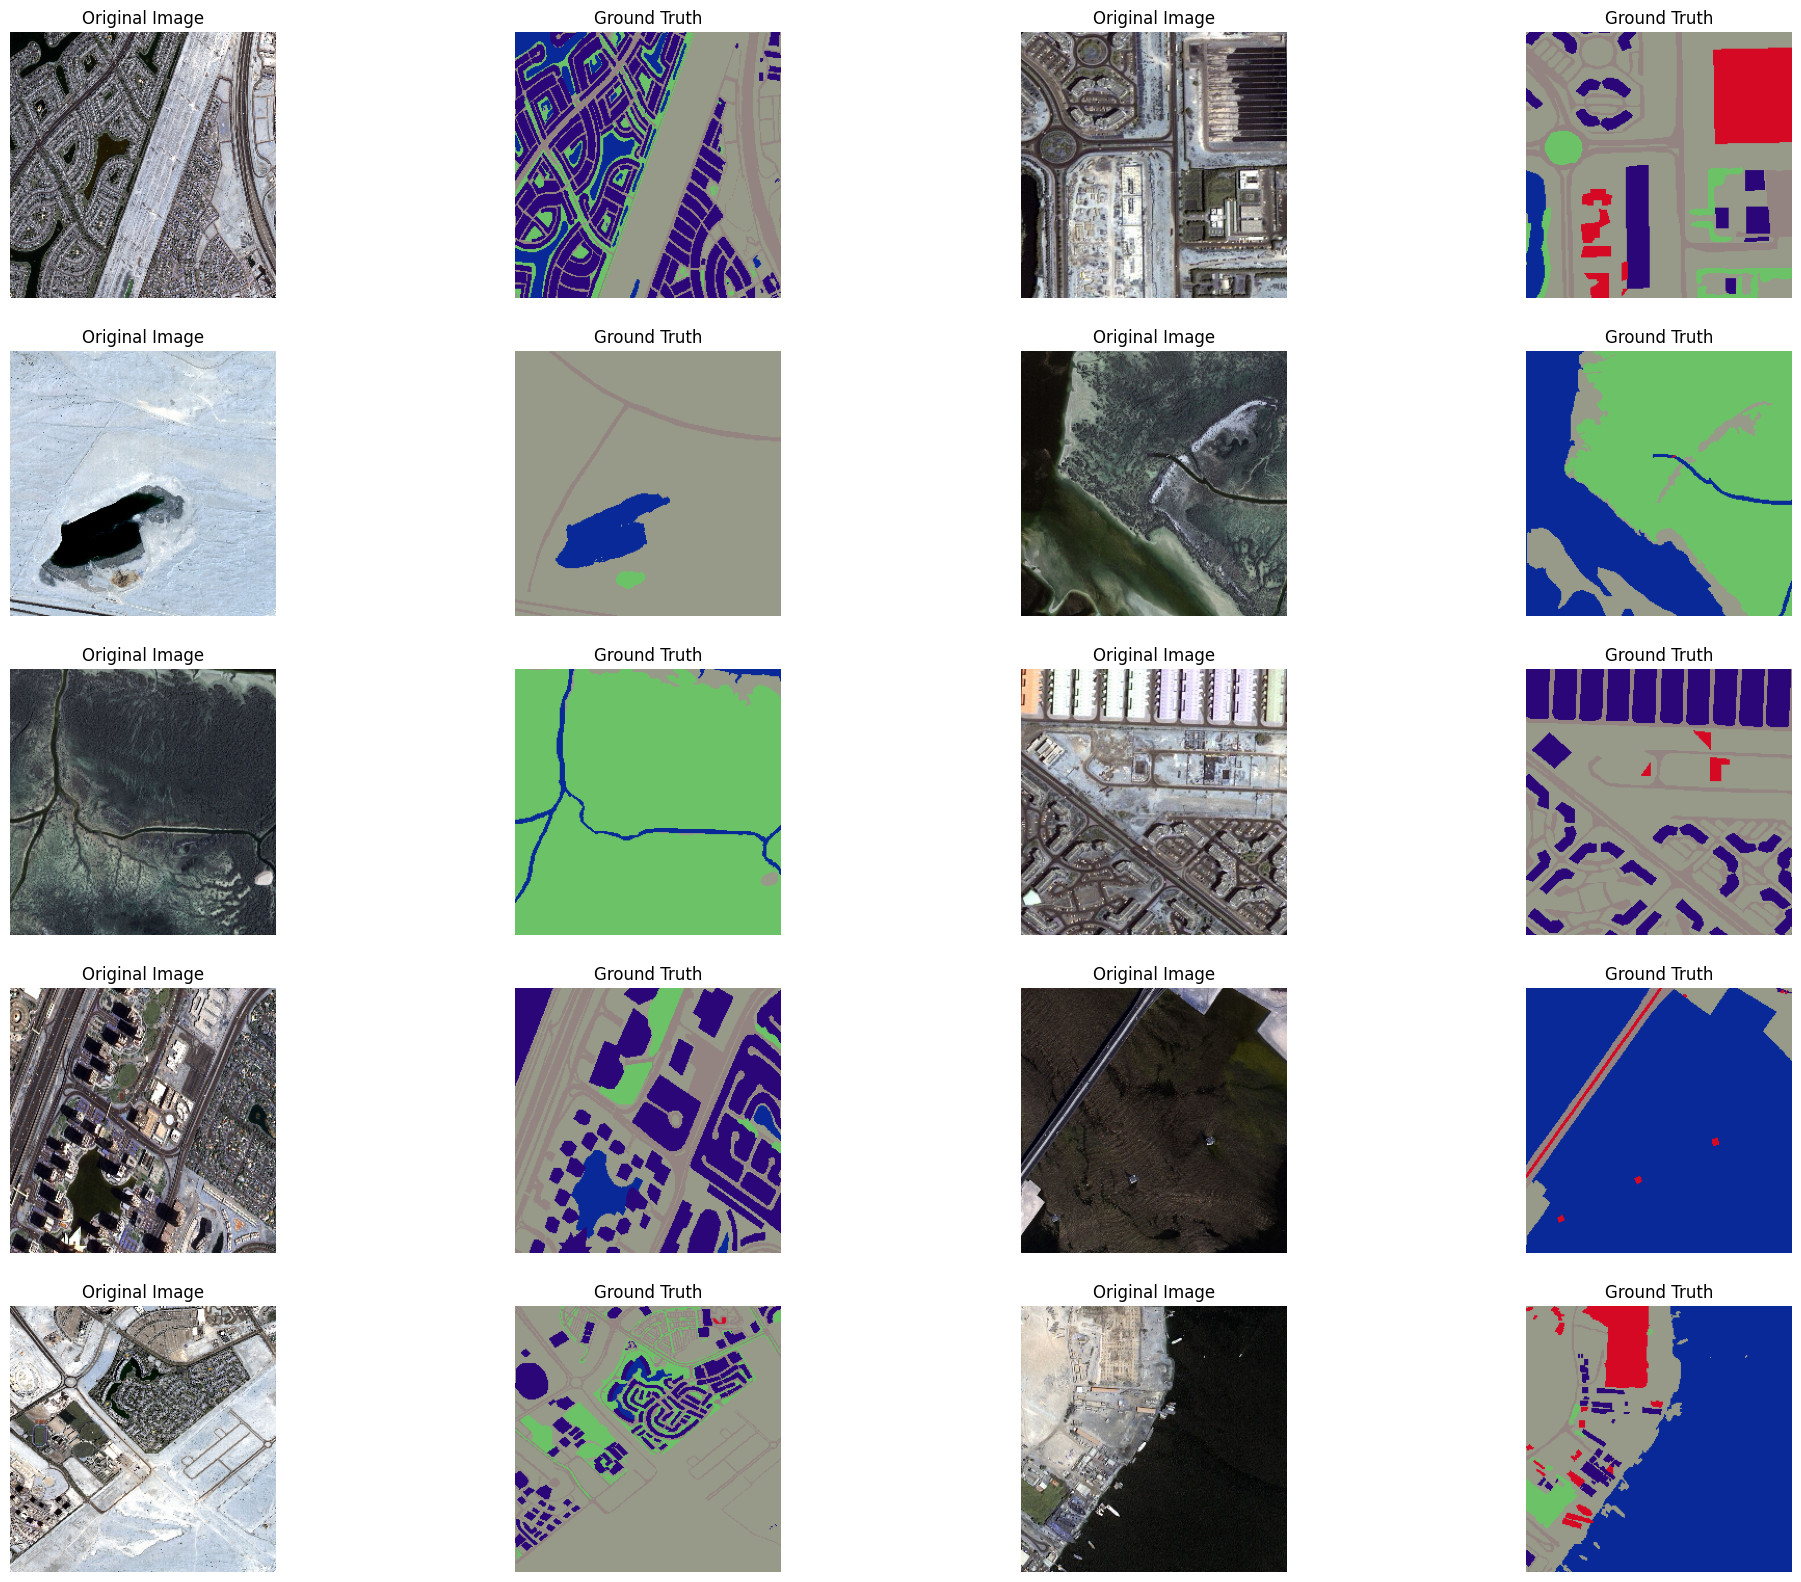

In [6]:
import random
from torchvision import transforms as tfs

def tn_2_np(t): 
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])
    
    rgb = True if len(t) == 3 else False
    
    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    
    for idx, index in enumerate(indices):
        
        if count == n_ims + 1: break
        im, gt = ds[index]
        
        # First Plot
        count = plot(rows, cols, count, im = im)
        
        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True, title="Ground Truth")
        
visualize(tr_dl.dataset, n_ims = 20)

In [14]:
#!pip3 install segmentation_models_pytorch
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(classes = n_cls)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

import time
from tqdm import tqdm
from torch.nn import functional as F

class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = n_cls):
        
        self.pred, self.gt = torch.argmax(F.softmax(pred, dim=1), dim = 1), gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) 
    
    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        
        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        
        with torch.no_grad():
            self.gt = torch.argmax(self.gt, dim = 1)
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                    
                else:
                    
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, torch.argmax(self.gt, dim = 1))

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

In [8]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, save_path = "saved_models"):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 7
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")
    
    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            
            preds = model(ims)
            
            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()
            
            tr_iou_ += met.mIoU()
            
            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()
            
            loss_.backward()
            opt.step()
            opt.zero_grad()
        
        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                

        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)
        
        if best_loss > (val_loss_):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        if val_loss_ > best_loss:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            
    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")
    
    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [16]:
history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 50, save_prefix = "aerial")

Start training process...
Epoch 1 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.06it/s]


Epoch 1 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 2.891 secs
Train Loss         -> 1.152
Train PA           -> 0.584
Train IoU          -> 0.497
Validation Loss    -> 1.402
Validation PA      -> 0.827
Validation IoU     -> 0.656

Loss decreased from inf to 1.402!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.15it/s]


Epoch 2 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 2.838 secs
Train Loss         -> 0.634
Train PA           -> 0.854
Train IoU          -> 0.719
Validation Loss    -> 0.791
Validation PA      -> 0.875
Validation IoU     -> 0.719

Loss decreased from 1.402 to 0.791!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.16it/s]


Epoch 3 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 2.678 secs
Train Loss         -> 0.471
Train PA           -> 0.871
Train IoU          -> 0.745
Validation Loss    -> 0.429
Validation PA      -> 0.877
Validation IoU     -> 0.704

Loss decreased from 0.791 to 0.429!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.49it/s]


Epoch 4 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 2.782 secs
Train Loss         -> 0.327
Train PA           -> 0.910
Train IoU          -> 0.808
Validation Loss    -> 0.296
Validation PA      -> 0.926
Validation IoU     -> 0.822

Loss decreased from 0.429 to 0.296!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.40it/s]


Epoch 5 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 2.796 secs
Train Loss         -> 0.334
Train PA           -> 0.898
Train IoU          -> 0.781
Validation Loss    -> 0.319
Validation PA      -> 0.885
Validation IoU     -> 0.719

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.34it/s]


Epoch 6 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 2.620 secs
Train Loss         -> 0.268
Train PA           -> 0.921
Train IoU          -> 0.820
Validation Loss    -> 0.264
Validation PA      -> 0.905
Validation IoU     -> 0.769

Loss decreased from 0.319 to 0.264!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.75it/s]


Epoch 7 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 2.724 secs
Train Loss         -> 0.237
Train PA           -> 0.925
Train IoU          -> 0.829
Validation Loss    -> 0.258
Validation PA      -> 0.906
Validation IoU     -> 0.771

Loss decreased from 0.264 to 0.258!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.89it/s]


Epoch 8 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 2.699 secs
Train Loss         -> 0.223
Train PA           -> 0.927
Train IoU          -> 0.836
Validation Loss    -> 0.254
Validation PA      -> 0.904
Validation IoU     -> 0.767

Loss decreased from 0.258 to 0.254!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.03it/s]


Epoch 9 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 2.722 secs
Train Loss         -> 0.236
Train PA           -> 0.921
Train IoU          -> 0.820
Validation Loss    -> 0.224
Validation PA      -> 0.926
Validation IoU     -> 0.821

Loss decreased from 0.254 to 0.224!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.31it/s]


Epoch 10 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 2.621 secs
Train Loss         -> 0.232
Train PA           -> 0.923
Train IoU          -> 0.823
Validation Loss    -> 0.219
Validation PA      -> 0.934
Validation IoU     -> 0.841

Loss decreased from 0.224 to 0.219!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.55it/s]


Epoch 11 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


Epoch 11 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process results: 

Train Time         -> 2.745 secs
Train Loss         -> 0.211
Train PA           -> 0.931
Train IoU          -> 0.845
Validation Loss    -> 0.211
Validation PA      -> 0.920
Validation IoU     -> 0.804

Loss decreased from 0.219 to 0.211!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.52it/s]


Epoch 12 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


Epoch 12 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process results: 

Train Time         -> 2.581 secs
Train Loss         -> 0.184
Train PA           -> 0.938
Train IoU          -> 0.852
Validation Loss    -> 0.236
Validation PA      -> 0.934
Validation IoU     -> 0.849

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.02it/s]


Epoch 13 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 13 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process results: 

Train Time         -> 2.723 secs
Train Loss         -> 0.203
Train PA           -> 0.930
Train IoU          -> 0.834
Validation Loss    -> 0.263
Validation PA      -> 0.911
Validation IoU     -> 0.785

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.97it/s]


Epoch 14 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 14 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process results: 

Train Time         -> 2.729 secs
Train Loss         -> 0.188
Train PA           -> 0.935
Train IoU          -> 0.843
Validation Loss    -> 0.221
Validation PA      -> 0.916
Validation IoU     -> 0.795

Loss decreased from 0.263 to 0.221!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.33it/s]


Epoch 15 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch 15 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process results: 

Train Time         -> 2.630 secs
Train Loss         -> 0.183
Train PA           -> 0.939
Train IoU          -> 0.854
Validation Loss    -> 0.278
Validation PA      -> 0.912
Validation IoU     -> 0.802

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.69it/s]


Epoch 16 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 16 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process results: 

Train Time         -> 2.808 secs
Train Loss         -> 0.198
Train PA           -> 0.935
Train IoU          -> 0.838
Validation Loss    -> 0.198
Validation PA      -> 0.928
Validation IoU     -> 0.826

Loss decreased from 0.278 to 0.198!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.60it/s]


Epoch 17 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


Epoch 17 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process results: 

Train Time         -> 2.787 secs
Train Loss         -> 0.159
Train PA           -> 0.943
Train IoU          -> 0.865
Validation Loss    -> 0.209
Validation PA      -> 0.931
Validation IoU     -> 0.834

Loss did not decrease for 5 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.79it/s]


Epoch 18 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 18 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process results: 

Train Time         -> 2.788 secs
Train Loss         -> 0.162
Train PA           -> 0.944
Train IoU          -> 0.862
Validation Loss    -> 0.205
Validation PA      -> 0.924
Validation IoU     -> 0.817

Loss decreased from 0.209 to 0.205!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.97it/s]


Epoch 19 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


Epoch 19 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process results: 

Train Time         -> 2.678 secs
Train Loss         -> 0.159
Train PA           -> 0.944
Train IoU          -> 0.859
Validation Loss    -> 0.201
Validation PA      -> 0.932
Validation IoU     -> 0.835

Loss decreased from 0.205 to 0.201!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.03it/s]


Epoch 20 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 20 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process results: 

Train Time         -> 2.754 secs
Train Loss         -> 0.147
Train PA           -> 0.947
Train IoU          -> 0.867
Validation Loss    -> 0.175
Validation PA      -> 0.939
Validation IoU     -> 0.854

Loss decreased from 0.201 to 0.175!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.77it/s]


Epoch 21 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 21 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process results: 

Train Time         -> 2.769 secs
Train Loss         -> 0.137
Train PA           -> 0.949
Train IoU          -> 0.878
Validation Loss    -> 0.180
Validation PA      -> 0.935
Validation IoU     -> 0.844

Loss did not decrease for 6 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.09it/s]


Epoch 22 validation process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]

Epoch 22 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process results: 

Train Time         -> 2.695 secs
Train Loss         -> 0.138
Train PA           -> 0.950
Train IoU          -> 0.878
Validation Loss    -> 0.195
Validation PA      -> 0.920
Validation IoU     -> 0.807

Loss did not decrease for 7 epoch(s)!
Stopping training process becuase loss value did not decrease for 7 epochs!
Train process is completed in 1.024 minutes.


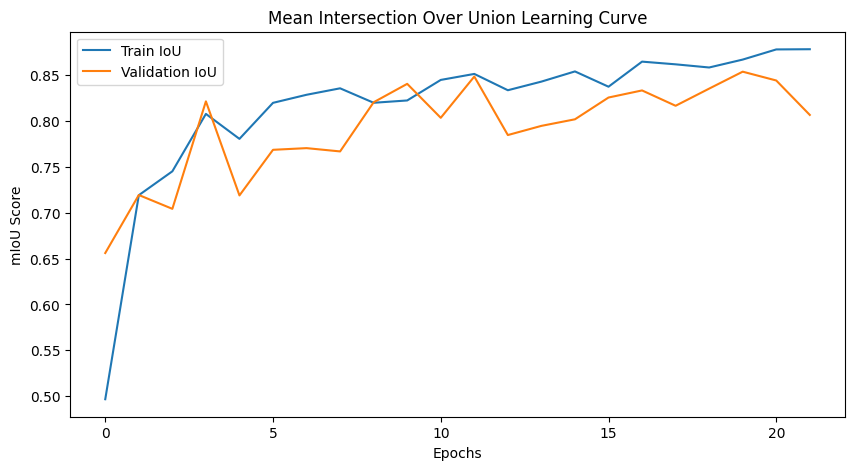

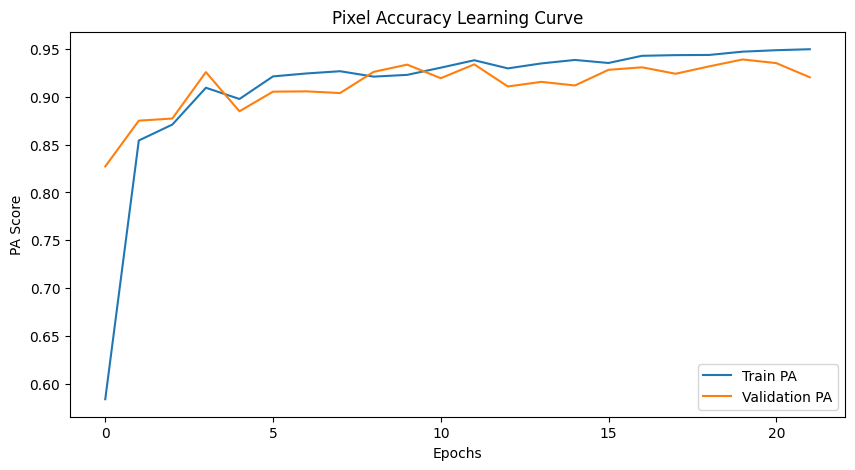

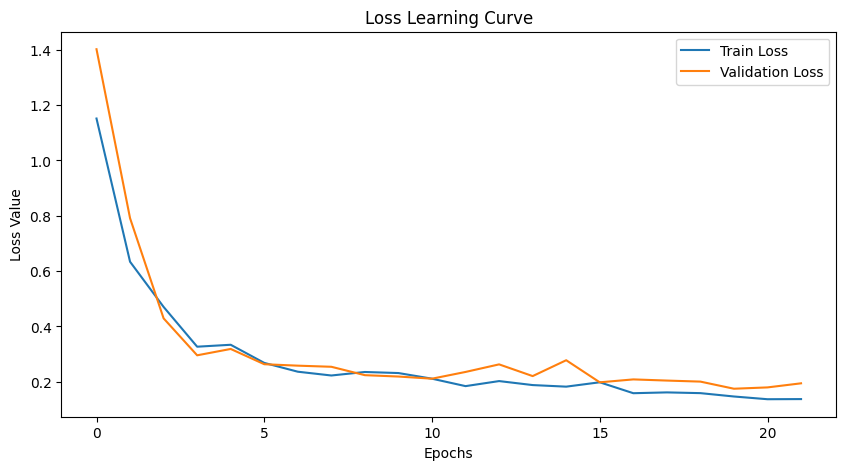

In [17]:
class Plot():
    
    def __init__(self, res):
        
        self.res = res
        
        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU", 
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")
    
        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA", 
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")
        
        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss", 
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")
        
        
    def plot(self, metric, label): plt.plot(self.res[metric], label = label)
    
    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()
    
    def visualize(self, metric1, metric2, label1, label2, title, ylabel):
        
        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)                
        
Plot(history)

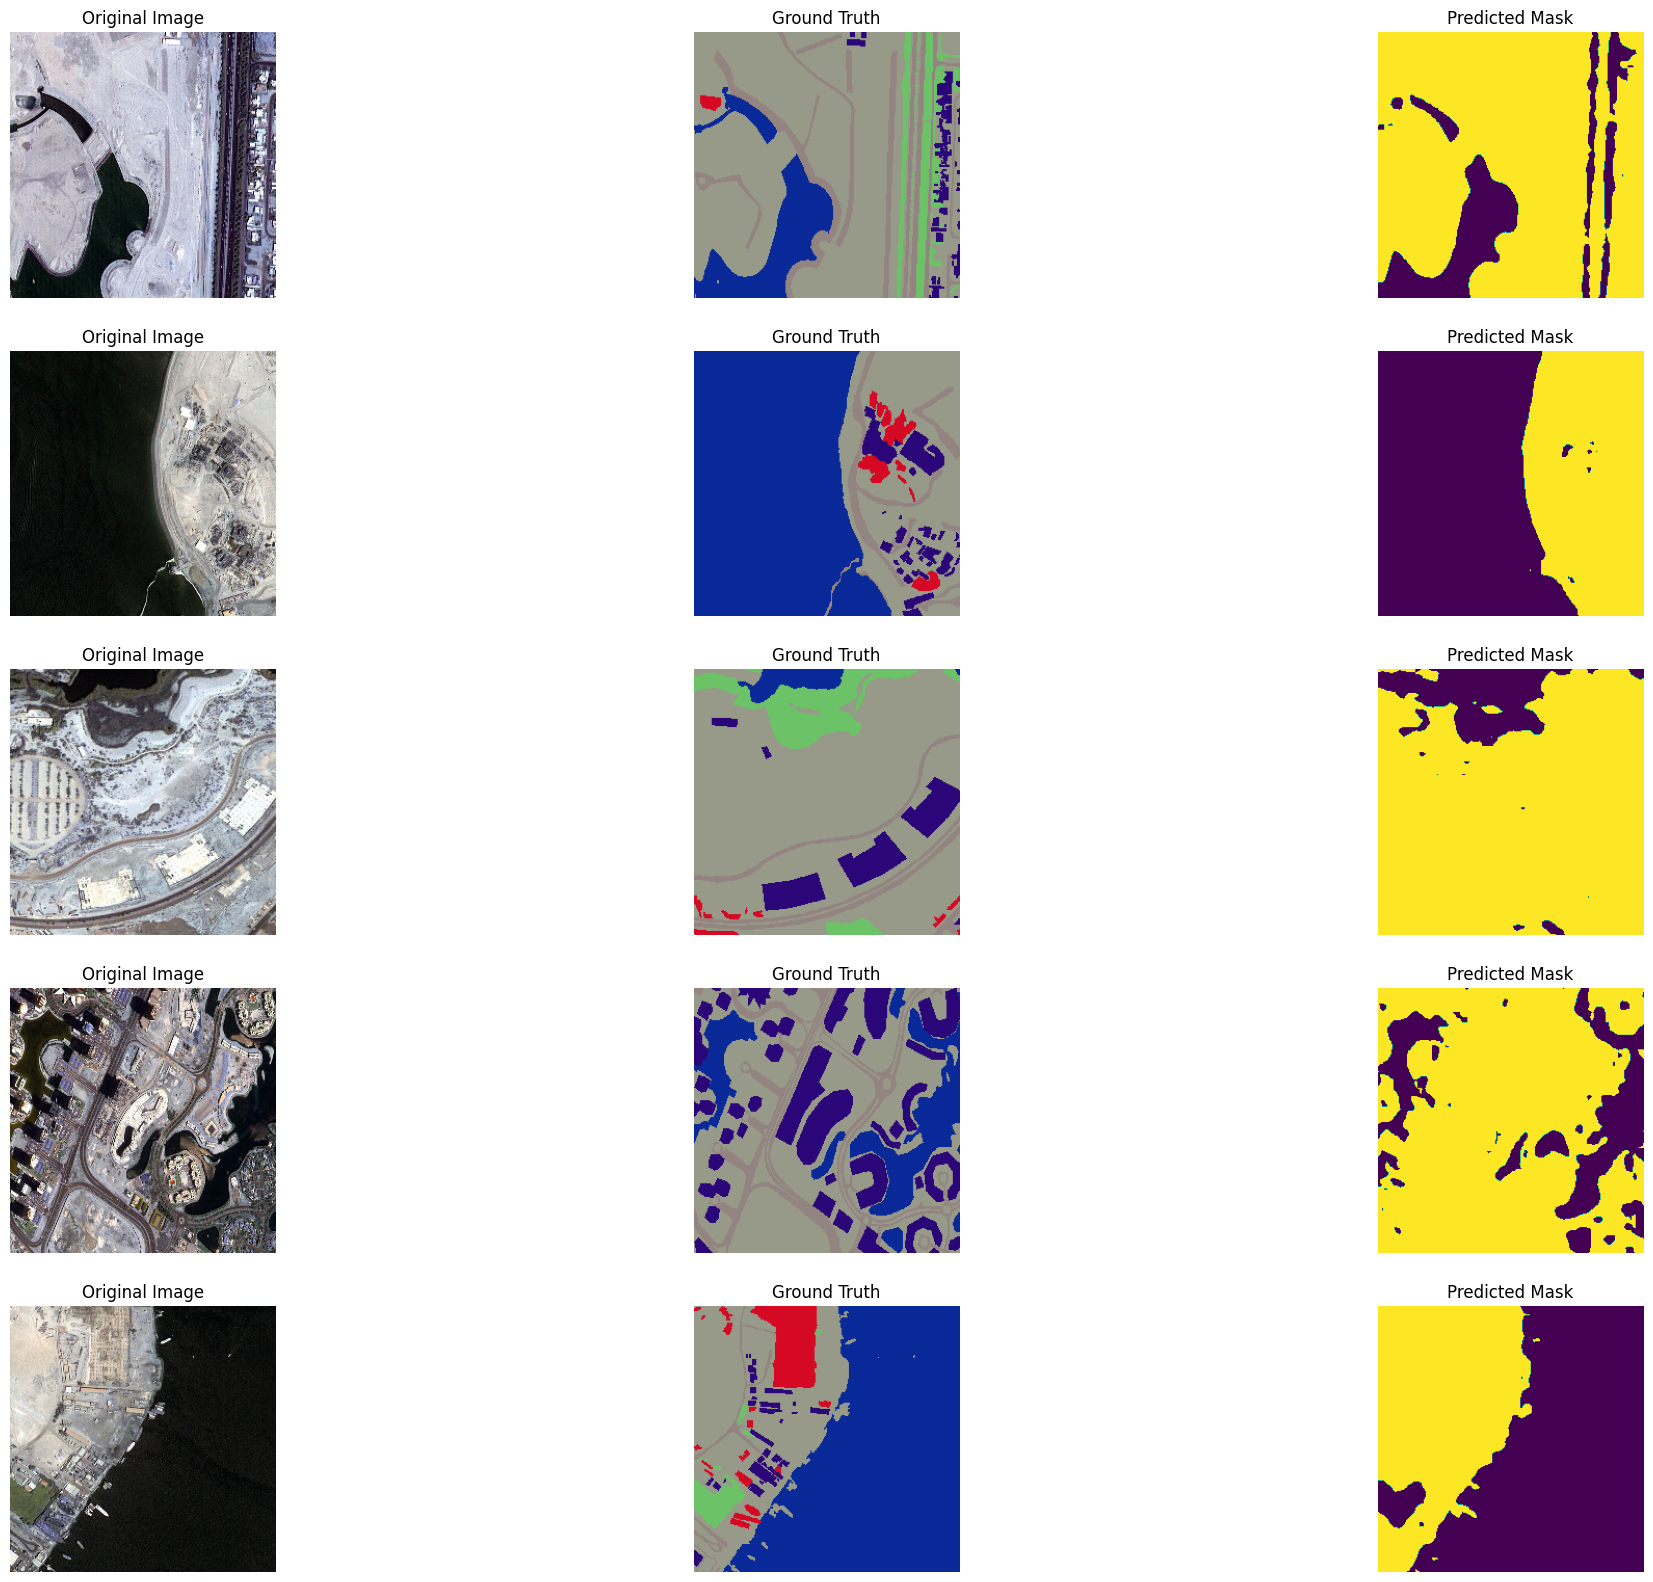

In [19]:
def inference(dl, model, device, n_ims = 15):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        
        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im = gt, gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, gt = True, title = "Predicted Mask")

model = torch.load("saved_models/aerial_best_model.pt")
inference(test_dl, model = model, device = device)

### DeepLabV3Plus ResNet101

In [7]:
#!pip3 install segmentation_models_pytorch
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(encoder_name='resnet101', classes = n_cls)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

import time
from tqdm import tqdm
from torch.nn import functional as F

class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = n_cls):
        
        self.pred, self.gt = torch.argmax(F.softmax(pred, dim=1), dim = 1), gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) 
    
    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        
        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        
        with torch.no_grad():
            self.gt = torch.argmax(self.gt, dim = 1)
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                    
                else:
                    
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, torch.argmax(self.gt, dim = 1))

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

/home/acf15802az/jupyter_seg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/acf15802az/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:00<00:00, 455MB/s]


In [ ]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, save_path = "saved_models"):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 7
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")
    
    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            
            preds = model(ims)
            
            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()
            
            tr_iou_ += met.mIoU()
            
            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()
            
            loss_.backward()
            opt.step()
            opt.zero_grad()
        
        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                

        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)
        
        if best_loss > (val_loss_):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        if val_loss_ > best_loss:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            
    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")
    
    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

In [9]:
history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 50, save_prefix = "aerial")

Start training process...
Epoch 1 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.76it/s]


Epoch 1 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 5.427 secs
Train Loss         -> 1.131
Train PA           -> 0.649
Train IoU          -> 0.531
Validation Loss    -> 1.362
Validation PA      -> 0.929
Validation IoU     -> 0.807

Loss decreased from inf to 1.362!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 2 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 3.454 secs
Train Loss         -> 0.592
Train PA           -> 0.857
Train IoU          -> 0.723
Validation Loss    -> 0.744
Validation PA      -> 0.942
Validation IoU     -> 0.843

Loss decreased from 1.362 to 0.744!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.19it/s]


Epoch 3 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 3.334 secs
Train Loss         -> 0.383
Train PA           -> 0.899
Train IoU          -> 0.795
Validation Loss    -> 0.317
Validation PA      -> 0.949
Validation IoU     -> 0.851

Loss decreased from 0.744 to 0.317!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.85it/s]


Epoch 4 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 3.169 secs
Train Loss         -> 0.350
Train PA           -> 0.898
Train IoU          -> 0.787
Validation Loss    -> 0.221
Validation PA      -> 0.958
Validation IoU     -> 0.880

Loss decreased from 0.317 to 0.221!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.68it/s]


Epoch 5 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 3.541 secs
Train Loss         -> 0.355
Train PA           -> 0.890
Train IoU          -> 0.763
Validation Loss    -> 0.175
Validation PA      -> 0.954
Validation IoU     -> 0.866

Loss decreased from 0.221 to 0.175!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.88it/s]


Epoch 6 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 3.187 secs
Train Loss         -> 0.252
Train PA           -> 0.925
Train IoU          -> 0.834
Validation Loss    -> 0.156
Validation PA      -> 0.954
Validation IoU     -> 0.867

Loss decreased from 0.175 to 0.156!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.42it/s]


Epoch 7 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 3.280 secs
Train Loss         -> 0.249
Train PA           -> 0.924
Train IoU          -> 0.829
Validation Loss    -> 0.176
Validation PA      -> 0.951
Validation IoU     -> 0.857

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.22it/s]


Epoch 8 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 3.364 secs
Train Loss         -> 0.209
Train PA           -> 0.930
Train IoU          -> 0.844
Validation Loss    -> 0.160
Validation PA      -> 0.952
Validation IoU     -> 0.864

Loss decreased from 0.176 to 0.160!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.41it/s]


Epoch 9 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 3.320 secs
Train Loss         -> 0.195
Train PA           -> 0.935
Train IoU          -> 0.857
Validation Loss    -> 0.163
Validation PA      -> 0.950
Validation IoU     -> 0.855

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.19it/s]


Epoch 10 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 3.350 secs
Train Loss         -> 0.177
Train PA           -> 0.938
Train IoU          -> 0.866
Validation Loss    -> 0.114
Validation PA      -> 0.962
Validation IoU     -> 0.889

Loss decreased from 0.163 to 0.114!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.51it/s]


Epoch 11 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Epoch 11 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process results: 

Train Time         -> 3.294 secs
Train Loss         -> 0.181
Train PA           -> 0.939
Train IoU          -> 0.861
Validation Loss    -> 0.115
Validation PA      -> 0.961
Validation IoU     -> 0.887

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.45it/s]


Epoch 12 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 12 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process results: 

Train Time         -> 3.304 secs
Train Loss         -> 0.207
Train PA           -> 0.925
Train IoU          -> 0.838
Validation Loss    -> 0.438
Validation PA      -> 0.933
Validation IoU     -> 0.825

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.15it/s]


Epoch 13 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 13 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process results: 

Train Time         -> 3.398 secs
Train Loss         -> 0.209
Train PA           -> 0.928
Train IoU          -> 0.840
Validation Loss    -> 0.167
Validation PA      -> 0.951
Validation IoU     -> 0.858

Loss decreased from 0.438 to 0.167!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.45it/s]


Epoch 14 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


Epoch 14 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process results: 

Train Time         -> 3.227 secs
Train Loss         -> 0.223
Train PA           -> 0.922
Train IoU          -> 0.827
Validation Loss    -> 0.132
Validation PA      -> 0.956
Validation IoU     -> 0.872

Loss decreased from 0.167 to 0.132!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.60it/s]


Epoch 15 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


Epoch 15 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process results: 

Train Time         -> 3.212 secs
Train Loss         -> 0.200
Train PA           -> 0.931
Train IoU          -> 0.840
Validation Loss    -> 0.132
Validation PA      -> 0.957
Validation IoU     -> 0.873

Loss decreased from 0.132 to 0.132!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 16 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch 16 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process results: 

Train Time         -> 3.413 secs
Train Loss         -> 0.177
Train PA           -> 0.940
Train IoU          -> 0.859
Validation Loss    -> 0.126
Validation PA      -> 0.955
Validation IoU     -> 0.867

Loss decreased from 0.132 to 0.126!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.07it/s]


Epoch 17 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


Epoch 17 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process results: 

Train Time         -> 3.378 secs
Train Loss         -> 0.156
Train PA           -> 0.946
Train IoU          -> 0.875
Validation Loss    -> 0.139
Validation PA      -> 0.955
Validation IoU     -> 0.868

Loss did not decrease for 5 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 18 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch 18 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process results: 

Train Time         -> 3.437 secs
Train Loss         -> 0.152
Train PA           -> 0.947
Train IoU          -> 0.871
Validation Loss    -> 0.145
Validation PA      -> 0.955
Validation IoU     -> 0.869

Loss did not decrease for 6 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.62it/s]


Epoch 19 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


Epoch 19 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process results: 

Train Time         -> 3.273 secs
Train Loss         -> 0.135
Train PA           -> 0.950
Train IoU          -> 0.890
Validation Loss    -> 0.124
Validation PA      -> 0.957
Validation IoU     -> 0.876

Loss decreased from 0.145 to 0.124!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.50it/s]


Epoch 20 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch 20 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process results: 

Train Time         -> 3.224 secs
Train Loss         -> 0.141
Train PA           -> 0.950
Train IoU          -> 0.882
Validation Loss    -> 0.116
Validation PA      -> 0.959
Validation IoU     -> 0.880

Loss decreased from 0.124 to 0.116!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.45it/s]


Epoch 21 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 21 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process results: 

Train Time         -> 3.273 secs
Train Loss         -> 0.135
Train PA           -> 0.949
Train IoU          -> 0.884
Validation Loss    -> 0.103
Validation PA      -> 0.964
Validation IoU     -> 0.896

Loss decreased from 0.116 to 0.103!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process is started...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 22 validation process is started...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

Epoch 22 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process results: 

Train Time         -> 3.382 secs
Train Loss         -> 0.156
Train PA           -> 0.945
Train IoU          -> 0.870
Validation Loss    -> 0.121
Validation PA      -> 0.960
Validation IoU     -> 0.884

Loss did not decrease for 7 epoch(s)!
Stopping training process becuase loss value did not decrease for 7 epochs!
Train process is completed in 1.303 minutes.


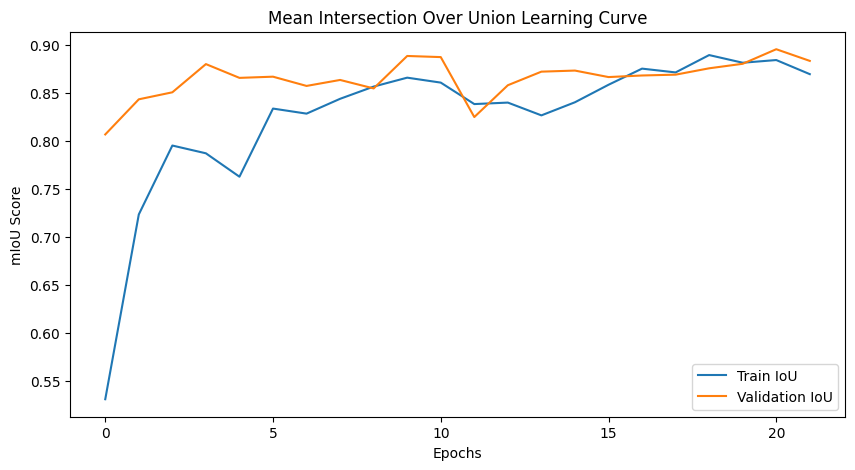

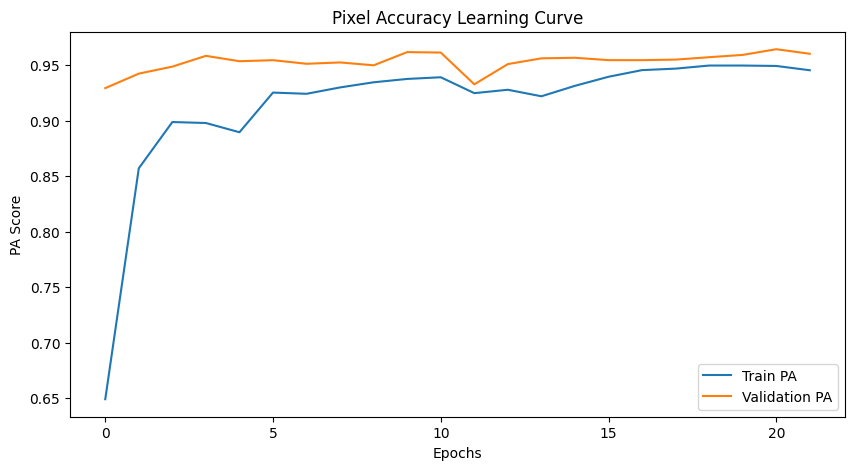

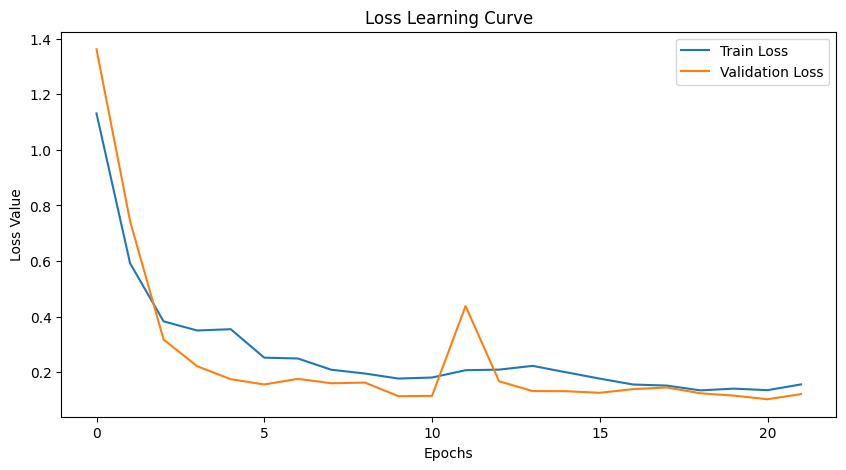

In [10]:
class Plot():
    
    def __init__(self, res):
        
        self.res = res
        
        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU", 
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")
    
        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA", 
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")
        
        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss", 
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")
        
        
    def plot(self, metric, label): plt.plot(self.res[metric], label = label)
    
    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()
    
    def visualize(self, metric1, metric2, label1, label2, title, ylabel):
        
        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)                
        
Plot(history)

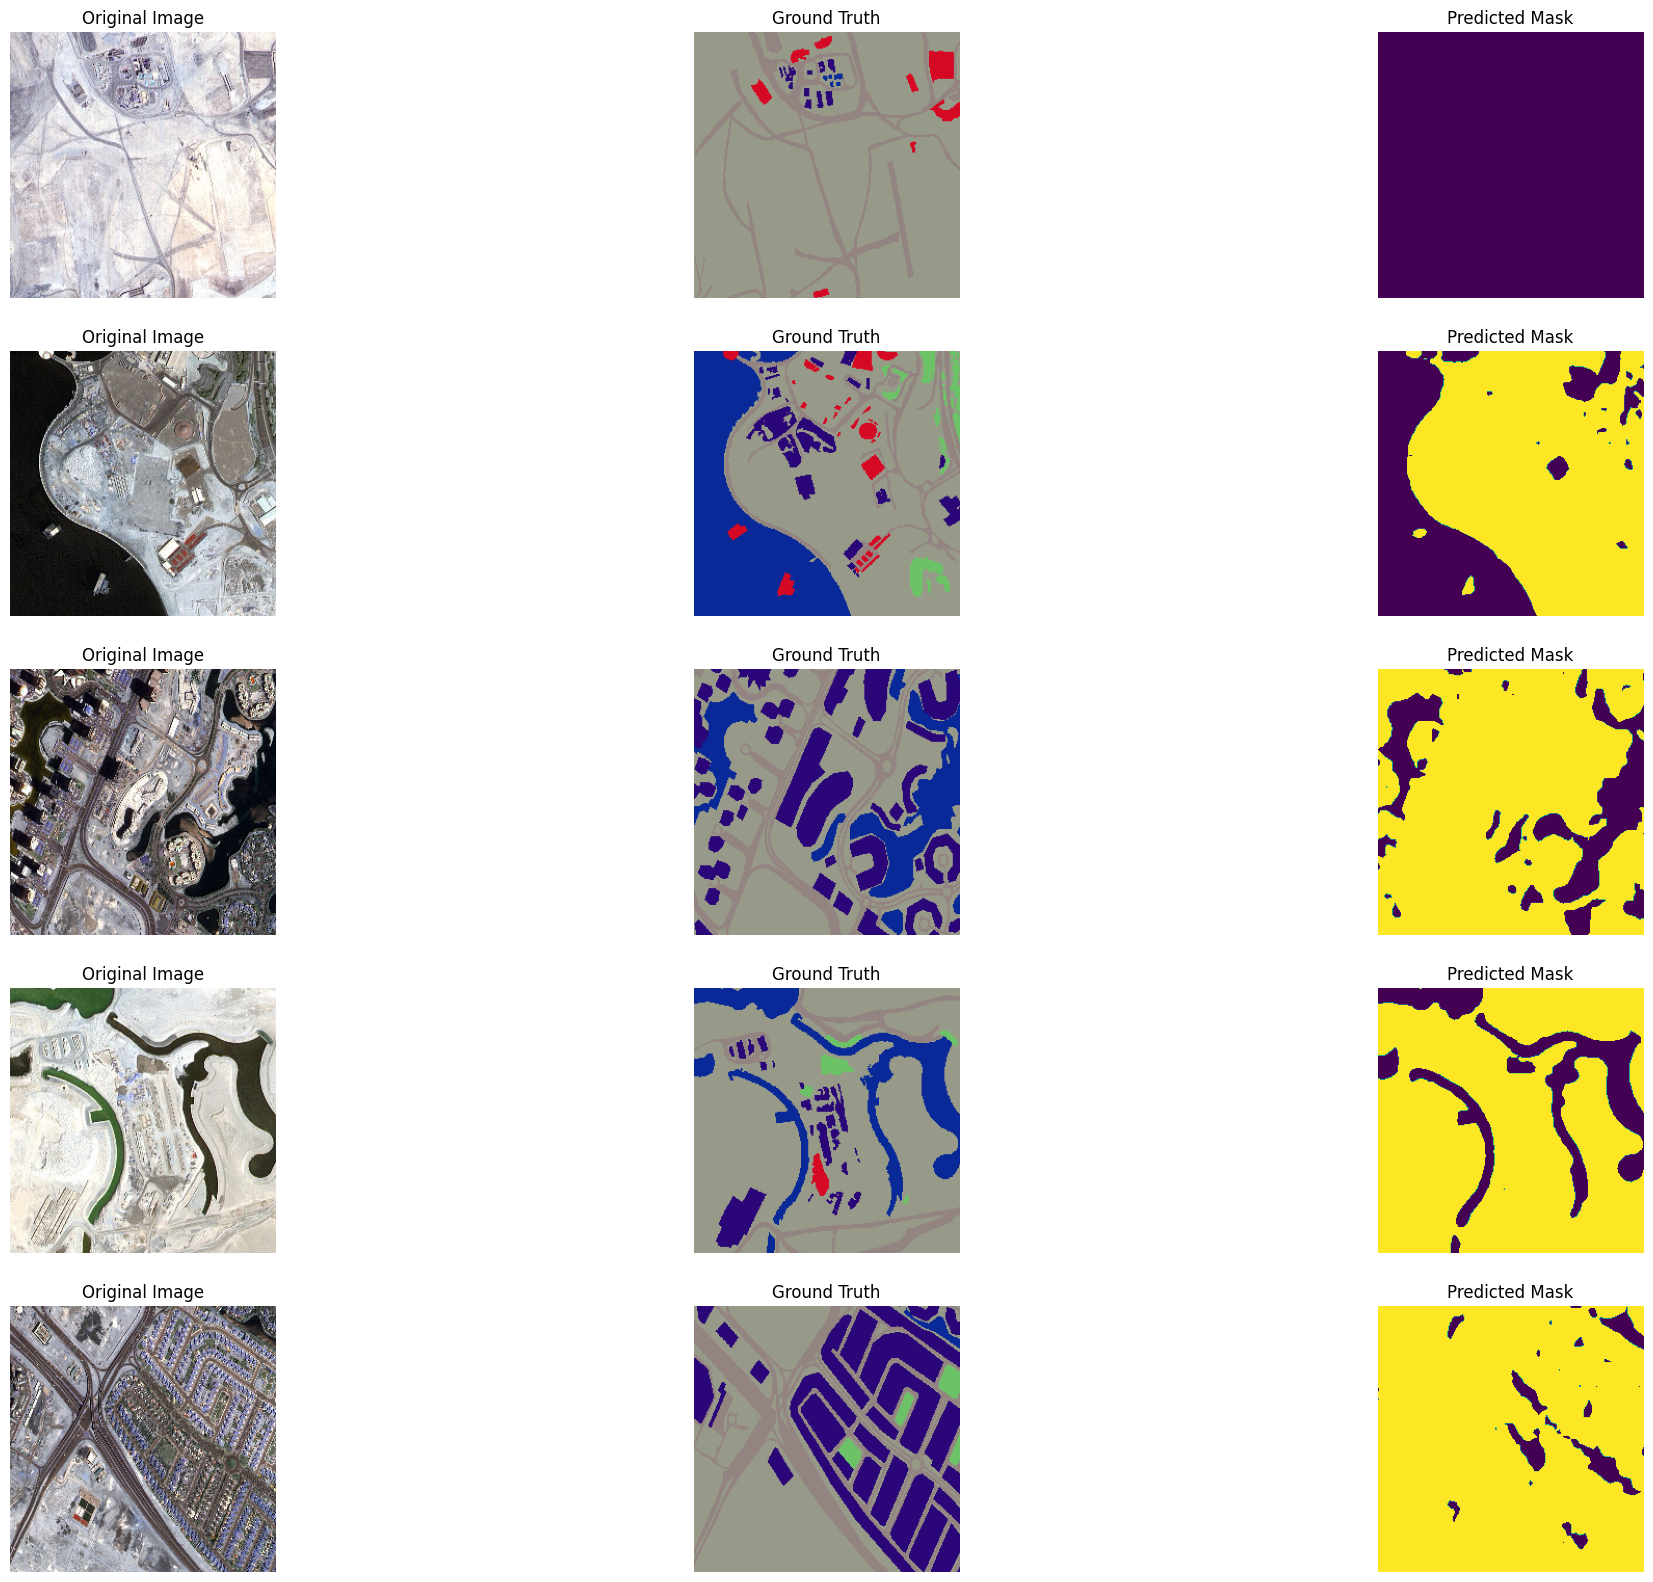

In [11]:
def inference(dl, model, device, n_ims = 15):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        
        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im = gt, gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, gt = True, title = "Predicted Mask")

model = torch.load("saved_models/aerial_best_model.pt")
inference(test_dl, model = model, device = device)